# Parsimonious models plot using 1, 3, 5, 7 features for the best performing model


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append('../src')

In [3]:
import utils
import model_selection
import models
import plotting 
import delong
import shap_plots
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer

In [13]:
# read data
all_data = utils.load_unformatted_data('../data/retrospective_influenza_dataset/20191105 resp data no filter revised 1 2020.csv', '../data/retrospective_influenza_dataset/Sample_key_csv revised 1 2020.csv')
all_data = utils.map_label_column(all_data)
all_data, flu_mapping, subtype_mapping = utils.encode_labels(all_data)

# drop zero cols
all_data = all_data.loc[:, all_data.any()]
col_names = all_data.columns[:-2]

# train test split
train, test = utils.train_test_split(all_data, test_size=50)

In [14]:
test.flu.value_counts()

0    26
1    24
Name: flu, dtype: int64

In [15]:
flu_mapping

{'Flu': 1, 'negative': 0}

In [16]:
# split into data
X_train, y_train = utils.df_to_array(train)
X_test, y_test = utils.df_to_array(test)

In [17]:
#processor = utils.CustomPreprocessor(transforms = ['clip', 'noise', 'power'])
#processor = utils.CustomPreprocessor(transforms = ['standard'])
processor = utils.CustomPreprocessor(transforms = ['quantile'])
processor.fit(X_train)
norm_X_train = processor.transform(X_train)
norm_X_test = processor.transform(X_test)

n_quantiles (1000) is greater than the total number of samples (186). n_quantiles is set to n_samples.


# Get Top Features

In [18]:
import shap_plots
import pickle
with open('model_output_v3.pkl', 'rb') as f:
    output = pickle.load(f)

In [19]:
# get top feature bar plot for LGBM model
lgbm_model = output['LGBM']['model']
shap_values = lgbm_model.cv_shap_values(norm_X_test, y_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [20]:
_, _, top_features = shap_plots.get_feature_importance(shap_values, norm_X_test, col_names, 20)

# Train and Evaluate Parsimonious Models

In [21]:
from models import LGBM
from models import DecisionTree
from sklearn.tree import DecisionTreeClassifier
import delong

num_features = [1, 3, 5, 7]
output = {}
for n in num_features:
    cols_to_use = list(top_features)[:n]
    
    # Select input data
    temp = all_data.loc[:,  cols_to_use + ['flu', 'subtype']]
    train, test = utils.train_test_split(temp, test_size=50)    
    X_train, y_train = utils.df_to_array(train)
    X_test, y_test = utils.df_to_array(test)
    
    # Preprocess
    processor = utils.CustomPreprocessor(transforms = ['quantile'])
    processor.fit(X_train)
    norm_X_train = processor.transform(X_train)
    norm_X_test = processor.transform(X_test)
    
    # Train - Unused in favor of decision tree
    """
    lgbm_model = LGBM('LGBM', {'n_jobs': -1})
    best_params = lgbm_model.random_search(4, norm_X_train, y_train)
    lgbm_model = LGBM('LGBM', best_params)
    lgbm_model.run_cv(norm_X_train, y_train, 4)
    
    # Test
    y_train_prob = lgbm_model.avgd_folds_decision_function(norm_X_train)
    y_pred_prob = lgbm_model.avgd_folds_decision_function(norm_X_test)
    """
    """
    # Decision tree
    tree_model = DecisionTreeClassifier(max_depth=n, random_state=2020)
    tree_model.fit(norm_X_train, y_train)
    y_train_prob = tree_model.predict(norm_X_train)
    y_pred_prob = tree_model.predict(norm_X_test)
    
    """
    # Train using decision tree - Cross validation
    tree_model = DecisionTree('DecisionTree', {'max_depth':n})
    best_params = tree_model.random_search(4, norm_X_train, y_train)
    best_params['max_depth'] = n
    tree_model = DecisionTree('LGBM', best_params)
    tree_model.run_cv(norm_X_train, y_train, 4)
    
    # Test
    y_train_prob = tree_model.avgd_folds_decision_function(norm_X_train)
    y_pred_prob = tree_model.avgd_folds_decision_function(norm_X_test)
    

    # Get AUC and 95% CI
    fpr, tpr, a = lgbm_model.get_prediction_stats(y_test, y_pred_prob)
    lower, upper = delong.compute_stats(.95, y_pred_prob, y_test)
    
    # Save Output
    output[n] = {
        'model': tree_model,
        'y_test': y_test,
        'y_pred_prob': y_pred_prob,
        'auc': a,
        'lower': lower,
        'upper': upper
    }

n_quantiles (1000) is greater than the total number of samples (186). n_quantiles is set to n_samples.
Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parall

Fitting 4 folds for each of 135 candidates, totalling 540 fits
[CV] max_depth=1, min_samples_split=2 ................................
[CV] .... max_depth=1, min_samples_split=2, score=0.766, total=   0.0s
[CV] max_depth=1, min_samples_split=2 ................................
[CV] .... max_depth=1, min_samples_split=2, score=0.894, total=   0.0s
[CV] max_depth=1, min_samples_split=2 ................................
[CV] .... max_depth=1, min_samples_split=2, score=0.935, total=   0.0s
[CV] max_depth=1, min_samples_split=2 ................................
[CV] .... max_depth=1, min_samples_split=2, score=0.870, total=   0.0s
[CV] max_depth=1, min_samples_split=3 ................................
[CV] .... max_depth=1, min_samples_split=3, score=0.766, total=   0.0s
[CV] max_depth=1, min_samples_split=3 ................................
[CV] .... max_depth=1, min_samples_split=3, score=0.894, total=   0.0s
[CV] max_depth=1, min_samples_split=3 ................................
[CV] .... max_

[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:    0.7s finished
Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
n_quantiles (1000) is greater than the total number of samples (186). n_quantiles is set to n_samples.
Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Paralle

[CV] .... max_depth=3, min_samples_split=2, score=0.891, total=   0.0s
[CV] max_depth=3, min_samples_split=2 ................................
[CV] .... max_depth=3, min_samples_split=2, score=0.870, total=   0.0s
[CV] max_depth=3, min_samples_split=3 ................................
[CV] .... max_depth=3, min_samples_split=3, score=0.766, total=   0.0s
[CV] max_depth=3, min_samples_split=3 ................................
[CV] .... max_depth=3, min_samples_split=3, score=0.872, total=   0.0s
[CV] max_depth=3, min_samples_split=3 ................................
[CV] .... max_depth=3, min_samples_split=3, score=0.891, total=   0.0s
[CV] max_depth=3, min_samples_split=3 ................................
[CV] .... max_depth=3, min_samples_split=3, score=0.870, total=   0.0s
[CV] max_depth=3, min_samples_split=5 ................................
[CV] .... max_depth=3, min_samples_split=5, score=0.766, total=   0.0s
[CV] max_depth=3, min_samples_split=5 ................................
[CV] .

[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:    0.6s finished
Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
n_quantiles (1000) is greater than the total number of samples (186). n_quantiles is set to n_samples.
Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Paralle

[CV] ... max_depth=1, min_samples_split=16, score=0.935, total=   0.0s
[CV] max_depth=1, min_samples_split=16 ...............................
[CV] ... max_depth=1, min_samples_split=16, score=0.870, total=   0.0s
[CV] max_depth=1, min_samples_split=32 ...............................
[CV] ... max_depth=1, min_samples_split=32, score=0.766, total=   0.0s
[CV] max_depth=1, min_samples_split=32 ...............................
[CV] ... max_depth=1, min_samples_split=32, score=0.894, total=   0.0s
[CV] max_depth=1, min_samples_split=32 ...............................
[CV] ... max_depth=1, min_samples_split=32, score=0.935, total=   0.0s
[CV] max_depth=1, min_samples_split=32 ...............................
[CV] ... max_depth=1, min_samples_split=32, score=0.870, total=   0.0s
[CV] max_depth=2, min_samples_split=2 ................................
[CV] .... max_depth=2, min_samples_split=2, score=0.766, total=   0.0s
[CV] max_depth=2, min_samples_split=2 ................................
[CV] .

[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:    0.7s finished
Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
n_quantiles (1000) is greater than the total number of samples (186). n_quantiles is set to n_samples.
Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Paralle

[CV] .... max_depth=3, min_samples_split=7, score=0.851, total=   0.0s
[CV] max_depth=3, min_samples_split=7 ................................
[CV] .... max_depth=3, min_samples_split=7, score=0.870, total=   0.0s
[CV] max_depth=3, min_samples_split=7 ................................
[CV] .... max_depth=3, min_samples_split=7, score=0.870, total=   0.0s
[CV] max_depth=3, min_samples_split=8 ................................
[CV] .... max_depth=3, min_samples_split=8, score=0.766, total=   0.0s
[CV] max_depth=3, min_samples_split=8 ................................
[CV] .... max_depth=3, min_samples_split=8, score=0.851, total=   0.0s
[CV] max_depth=3, min_samples_split=8 ................................
[CV] .... max_depth=3, min_samples_split=8, score=0.870, total=   0.0s
[CV] max_depth=3, min_samples_split=8 ................................
[CV] .... max_depth=3, min_samples_split=8, score=0.870, total=   0.0s
[CV] max_depth=3, min_samples_split=9 ................................
[CV] .

[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:    0.7s finished
Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


# Plot 

In [22]:
aucs = [output[i]['auc'] for i in num_features]
lowers = [output[i]['lower'] for i in num_features]
uppers = [output[i]['upper'] for i in num_features]

In [23]:
cis = [uppers[i] - aucs[i] for i in range(4)]

In [24]:
bounds = []
for idx, i in enumerate(aucs):
    lower = aucs[idx] - cis[idx]
    upper = aucs[idx] + cis[idx]
    bounds.append("{} - {}".format(round(lower, 3), round(upper, 3)))

In [25]:
bounds

['0.836 - 0.996', '0.889 - 1.0', '0.859 - 1.0', '0.835 - 1.0']

In [26]:
aucs_fmt = [round(i,3) for i in aucs]

In [27]:
for idx, i in enumerate(aucs):
    print(aucs[idx])
    print(aucs[idx] - cis[idx])
    print(aucs[idx] + cis[idx])
    print()

0.9158653846153847
0.8361555320519133
0.9955752371788561

0.9447115384615384
0.8894230769230769
1.0

0.9294871794871795
0.858974358974359
1.0

0.9174679487179487
0.8349358974358974
1.0



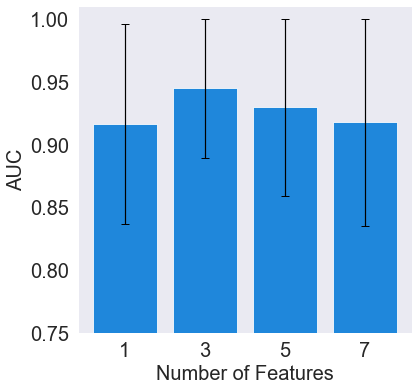

In [28]:
%matplotlib inline
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 22})
from shap.plots.colors import red_blue
sns.set_style('dark')
sns.set_context('paper')
fig, ax = plt.subplots(1, 1, figsize=(6,6))
sns.barplot(x=num_features, y=aucs, ax=ax, color=red_blue(0))
ax.errorbar(x=[0,1,2,3],y=aucs, yerr=cis, xerr=0, ls='none', color='black', capsize=4)
ax.set_ylim(.75, 1.01)
ax.set_xlabel("Number of Features")
ax.set_ylabel("AUC")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)



plt.savefig("AUC_parsimonious.svg", bbox_inches='tight')

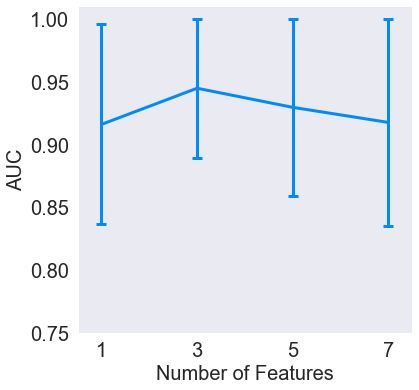

In [29]:
%matplotlib inline
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 22})
from shap.plots.colors import red_blue
fig, ax = plt.subplots(1, 1, figsize=(6,6))
#ax.plot(num_features, y=aucs, ax=ax)
ax.errorbar(x=[1,3,5,7], y=aucs, yerr=cis, xerr=0, color=red_blue(0), capsize=5, linewidth=3, capthick=3)
ax.set_ylim(.75, 1.01)
ax.set_xlim(.5,7.5)
ax.set_xlabel("Number of Features")
ax.set_ylabel("AUC")
ax.set_xticks(range(1,8,2))
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

plt.savefig('AUC_line.svg', bbox_inches='tight')

# Add Prospective Dataset to the Parsimonious Models

In [30]:
top_features = [
    '0.81_84.0447m/z', 
    '0.81_130.0507m/z', 
    '10.34_106.0865m/z',
    '4.73_422.1307m/z', 
    '9.34_349.0774n', 
    '10.87_249.1085m/z',
    '9.28_956.3750n', 
    '10.89_352.2131n', 
    '7.88_86.0965m/z',
    '1.78_63.0440m/z', 
    '10.85_214.1306m/z', 
    '8.36_144.0935n',
    '10.23_227.0793m/z', 
    '8.65_211.1376m/z', 
    '1.30_230.0961m/z',
    '10.33_178.1441m/z', 
    '11.61_102.1268m/z', 
    '2.11_232.1182m/z',
    '7.00_634.7114m/z', 
    '3.21_201.0740m/z'
]

In [32]:
# read prospective datasample
prospective_data = pd.read_csv('../data/prospective_influenza_dataset/2020 03 02 virology exported results.csv', index_col=None)
prospective_labels = pd.read_csv('../data/prospective_influenza_dataset/2020 03 02 sample key.csv')
flu_labels = prospective_labels['Unnamed: 1'].values[2:]
flu_mapping = {'negative': 0, 'positive': 1}
flu_labels = [flu_mapping[i] for i in flu_labels]

In [33]:
prospective_data['Name'] = top_features
prospective_data = prospective_data.transpose().iloc[1:, :]
prospective_data.columns = top_features
prospective_data['flu'] = flu_labels
prospective_data['subtype'] = flu_labels

In [34]:
from models import LGBM
from models import DecisionTree
from sklearn.tree import DecisionTreeClassifier
import delong

num_features = [1, 3, 5, 7]
output = {}

for n in num_features:
    cols_to_use = list(top_features)[:n]
    
    # Select input data
    temp = all_data.loc[:,  cols_to_use + ['flu', 'subtype']]
    train, test = utils.train_test_split(temp, test_size=50)    
    X_train, y_train = utils.df_to_array(train)
    X_test, y_test = utils.df_to_array(test)
    
    # Preprocess
    processor = utils.CustomPreprocessor(transforms = ['quantile'])
    processor.fit(X_train)
    norm_X_train = processor.transform(X_train)
    norm_X_test = processor.transform(X_test)
    
    # Preprocess Parsimonious 
    temp = prospective_data.loc[:,  cols_to_use + ['flu', 'subtype']]
    p_X_test, p_y_test = utils.df_to_array(temp)
    norm_p_X_test = processor.transform(p_X_test)
    
    # Train using decision tree - Cross validation
    tree_model = DecisionTree('DecisionTree', {'max_depth':n})
    best_params = tree_model.random_search(4, norm_X_train, y_train)
    best_params['max_depth'] = n
    tree_model = DecisionTree('LGBM', best_params)
    tree_model.run_cv(norm_X_train, y_train, 4)
    
    # Test
    y_train_prob = tree_model.avgd_folds_decision_function(norm_X_train)
    y_pred_prob = tree_model.avgd_folds_decision_function(norm_X_test)
    
    # Parsimonious Test
    y_prospective_pred_prob = tree_model.avgd_folds_decision_function(norm_p_X_test)
    
    # Get AUC and 95% CI
    fpr, tpr, a = lgbm_model.get_prediction_stats(y_test, y_pred_prob)
    lower, upper = delong.compute_stats(.95, y_pred_prob, y_test)
    
    # Get prospective set AUC and 95% CI
    p_fpr, p_tpr, p_a = lgbm_model.get_prediction_stats(p_y_test, y_prospective_pred_prob)
    p_lower, p_upper = delong.compute_stats(.95, y_prospective_pred_prob, p_y_test)
    
    # Save Output
    output[n] = {
        'model': tree_model,
        #'y_test': y_test,
        #'y_pred_prob': y_pred_prob,
        'auc': a,
        'lower': lower,
        'upper': upper,
        #'y_prospective_pred_prob': y_prospective_pred_prob,
        'prospective_auc': p_a,
        'prospective_upper': p_upper,
        'prospective_lower': p_lower,
        #'norm_p_X_test': norm_p_X_test
    }

n_quantiles (1000) is greater than the total number of samples (186). n_quantiles is set to n_samples.
Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parall

Fitting 4 folds for each of 135 candidates, totalling 540 fits
[CV] max_depth=1, min_samples_split=2 ................................
[CV] .... max_depth=1, min_samples_split=2, score=0.766, total=   0.0s
[CV] max_depth=1, min_samples_split=2 ................................
[CV] .... max_depth=1, min_samples_split=2, score=0.894, total=   0.0s
[CV] max_depth=1, min_samples_split=2 ................................
[CV] .... max_depth=1, min_samples_split=2, score=0.935, total=   0.0s
[CV] max_depth=1, min_samples_split=2 ................................
[CV] .... max_depth=1, min_samples_split=2, score=0.870, total=   0.0s
[CV] max_depth=1, min_samples_split=3 ................................
[CV] .... max_depth=1, min_samples_split=3, score=0.766, total=   0.0s
[CV] max_depth=1, min_samples_split=3 ................................
[CV] .... max_depth=1, min_samples_split=3, score=0.894, total=   0.0s
[CV] max_depth=1, min_samples_split=3 ................................
[CV] .... max_

[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:    0.6s finished
Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
invalid value encountered in multiply
invalid value encountered in multiply
invalid value encountered in greater
n_quantiles (1000) is greater than the total number of samples (186). n_quantiles is set to n_samples.
Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   

[CV] ... max_depth=3, min_samples_split=10, score=0.870, total=   0.0s
[CV] max_depth=3, min_samples_split=11 ...............................
[CV] ... max_depth=3, min_samples_split=11, score=0.766, total=   0.0s
[CV] max_depth=3, min_samples_split=11 ...............................
[CV] ... max_depth=3, min_samples_split=11, score=0.851, total=   0.0s
[CV] max_depth=3, min_samples_split=11 ...............................
[CV] ... max_depth=3, min_samples_split=11, score=0.935, total=   0.0s
[CV] max_depth=3, min_samples_split=11 ...............................
[CV] ... max_depth=3, min_samples_split=11, score=0.870, total=   0.0s
[CV] max_depth=3, min_samples_split=12 ...............................
[CV] ... max_depth=3, min_samples_split=12, score=0.766, total=   0.0s
[CV] max_depth=3, min_samples_split=12 ...............................
[CV] ... max_depth=3, min_samples_split=12, score=0.851, total=   0.0s
[CV] max_depth=3, min_samples_split=12 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:    0.7s finished
Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
n_quantiles (1000) is greater than the total number of samples (186). n_quantiles is set to n_samples.
Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Paralle

[CV] ... max_depth=2, min_samples_split=10, score=0.870, total=   0.0s
[CV] max_depth=2, min_samples_split=11 ...............................
[CV] ... max_depth=2, min_samples_split=11, score=0.766, total=   0.0s
[CV] max_depth=2, min_samples_split=11 ...............................
[CV] ... max_depth=2, min_samples_split=11, score=0.851, total=   0.0s
[CV] max_depth=2, min_samples_split=11 ...............................
[CV] ... max_depth=2, min_samples_split=11, score=0.935, total=   0.0s
[CV] max_depth=2, min_samples_split=11 ...............................
[CV] ... max_depth=2, min_samples_split=11, score=0.870, total=   0.0s
[CV] max_depth=2, min_samples_split=12 ...............................
[CV] ... max_depth=2, min_samples_split=12, score=0.766, total=   0.0s
[CV] max_depth=2, min_samples_split=12 ...............................
[CV] ... max_depth=2, min_samples_split=12, score=0.851, total=   0.0s
[CV] max_depth=2, min_samples_split=12 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:    0.7s finished
Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
n_quantiles (1000) is greater than the total number of samples (186). n_quantiles is set to n_samples.
Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Paralle

[CV] .... max_depth=1, min_samples_split=7, score=0.935, total=   0.0s
[CV] max_depth=1, min_samples_split=7 ................................
[CV] .... max_depth=1, min_samples_split=7, score=0.870, total=   0.0s
[CV] max_depth=1, min_samples_split=8 ................................
[CV] .... max_depth=1, min_samples_split=8, score=0.766, total=   0.0s
[CV] max_depth=1, min_samples_split=8 ................................
[CV] .... max_depth=1, min_samples_split=8, score=0.894, total=   0.0s
[CV] max_depth=1, min_samples_split=8 ................................
[CV] .... max_depth=1, min_samples_split=8, score=0.935, total=   0.0s
[CV] max_depth=1, min_samples_split=8 ................................
[CV] .... max_depth=1, min_samples_split=8, score=0.870, total=   0.0s
[CV] max_depth=1, min_samples_split=9 ................................
[CV] .... max_depth=1, min_samples_split=9, score=0.766, total=   0.0s
[CV] max_depth=1, min_samples_split=9 ................................
[CV] .

[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:    0.7s finished
Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


In [39]:
output

{1: {'model': <models.DecisionTree at 0x11be07250>,
  'auc': 0.9158653846153847,
  'lower': 0.8361555320519131,
  'upper': 0.9955752371788561,
  'prospective_auc': 0.5,
  'prospective_upper': nan,
  'prospective_lower': nan},
 3: {'model': <models.DecisionTree at 0x12d9a1ed0>,
  'auc': 0.9807692307692307,
  'lower': 0.9477926444333491,
  'upper': 1.0,
  'prospective_auc': 0.7847222222222222,
  'prospective_upper': 0.8644496168060577,
  'prospective_lower': 0.7049948276383867},
 5: {'model': <models.DecisionTree at 0x12ee99b90>,
  'auc': 0.9951923076923077,
  'lower': 0.9846618643221831,
  'upper': 1.0,
  'prospective_auc': 0.9733072916666666,
  'prospective_upper': 1.0,
  'prospective_lower': 0.9389963676443775},
 7: {'model': <models.DecisionTree at 0x12d9a3050>,
  'auc': 0.9943910256410255,
  'lower': 0.9825967015425783,
  'upper': 1.0,
  'prospective_auc': 0.7434895833333334,
  'prospective_upper': 0.8241628659589307,
  'prospective_lower': 0.662816300707736}}

# Plot Prospective AUC with CI

In [40]:
aucs = [output[i]['auc'] for i in num_features]
lowers = [output[i]['lower'] for i in num_features]
uppers = [output[i]['upper'] for i in num_features]

In [41]:
paucs = [output[i]['prospective_auc'] for i in num_features]
plowers = [output[i]['prospective_lower'] for i in num_features]
puppers = [output[i]['prospective_upper'] for i in num_features]

In [42]:
cis = [uppers[i] - aucs[i] for i in range(4)]
pcis = [puppers[i] - paucs[i] for i in range(4)]

In [43]:
# easiest to join into a DF
data_df = pd.DataFrame({"AUC": aucs + paucs, 'cis': cis + pcis, 'num_features': num_features + num_features, 'set':['Retrospective']*len(aucs) + ['Prospective']*len(paucs)})                               

In [44]:
data_df

,AUC,cis,num_features,set
0,0.915865,0.079710,1,Retrospective
1,0.980769,0.019231,3,Retrospective
2,0.995192,0.004808,5,Retrospective
3,0.994391,0.005609,7,Retrospective
4,0.500000,NaN,1,Prospective
5,0.784722,0.079727,3,Prospective
6,0.973307,0.026693,5,Prospective
7,0.743490,0.080673,7,Prospective


In [45]:
data_df.fillna(value=0, inplace=True)

In [46]:
from matplotlib.colors import LinearSegmentedColormap
color_list = [(.263, .557, .749), (1, 1, 1), (.722, .059, .047)]  # B -> R
cmap = LinearSegmentedColormap.from_list('plot_map', color_list, N=100)

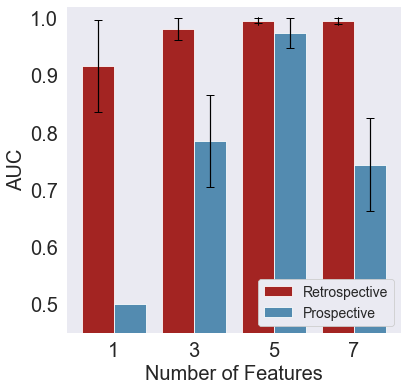

In [47]:
%matplotlib inline
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 22})
from shap.plots.colors import red_blue
sns.set_style('dark')
sns.set_context('paper')
fig, ax = plt.subplots(1, 1, figsize=(6,6))
sns.barplot(x='num_features', y='AUC', hue='set', ax=ax, data=data_df, palette=[(.722, .059, .047), (.263, .557, .749)])
ax.errorbar(x=np.array([0,1,2,3])-.2,y=aucs, yerr=cis, xerr=0, ls='none', color='black', capsize=4)

ax.errorbar(x=np.array([1,2,3])+.2,y=paucs[1:], yerr=pcis[1:], xerr=0, ls='none', color='black', capsize=4)

ax.set_ylim(.45, 1.02)
ax.set_xlabel("Number of Features")
ax.set_ylabel("AUC")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
ax.legend(loc='lower right', framealpha=1, fontsize=14)



plt.savefig("AUC_parsimonious_prospective.svg", bbox_inches='tight')